In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import skew, kurtosis
import statsmodels.api as sm
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
import os
from datetime import datetime
warnings.filterwarnings("ignore")
#pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [2]:
nifty_50 = pd.read_csv(r"D:\Macro Research\Data\Processed Data\Equity Benchmark\NIFTY50.csv", parse_dates=["Date"])
nifty_50.set_index("Date", inplace=True)
nifty_50_min_date = nifty_50.index.min()
nifty_50_max_date = nifty_50.index.max()

print(f"nifty_50_min_date: {nifty_50_min_date}")
print(f"nifty_50_max_date: {nifty_50_max_date}")
nifty_50.isna().sum()
nifty_midcap = pd.read_csv(r"D:\Macro Research\Data\Processed Data\Equity Benchmark\NIFTYMid.csv", parse_dates=["Date"])
nifty_midcap.set_index("Date", inplace=True)
nifty_midcap_min_date = nifty_midcap.first_valid_index()
nifty_midcap_max_date = nifty_midcap.last_valid_index()
print(f"nifty_midcap_min_date: {nifty_midcap_min_date}")
print(f"nifty_midcap_max_date: {nifty_midcap_max_date}")
nifty_midcap.isna().sum()
nifty_smallcap = pd.read_csv(r"D:\Macro Research\Data\Processed Data\Equity Benchmark\NIFTYSmall.csv",
                             parse_dates=["Date"])
nifty_smallcap.set_index("Date", inplace=True)
nifty_smallcap_min_date = nifty_smallcap.first_valid_index()
nifty_smallcap_max_date = nifty_smallcap.last_valid_index()

print(f"nifty_smallcap_min_date: {nifty_smallcap_min_date}")
print(f"nigty_smallcap_max_date: {nifty_smallcap_max_date}")
nifty_smallcap.isna().sum()
start_date = nifty_midcap_min_date
end_date = nifty_midcap_max_date
nifty_50[nifty_50.index >= start_date]
nifty_indices = pd.concat([nifty_50, nifty_midcap, nifty_smallcap], axis=1)
nifty_indices = nifty_indices[nifty_indices.index >= start_date]
nifty_indices.isna().sum()
nifty_indices = nifty_indices.dropna()
nifty_indices

nifty_50_min_date: 1995-12-29 00:00:00
nifty_50_max_date: 2025-11-14 00:00:00
nifty_midcap_min_date: 2005-07-18 00:00:00
nifty_midcap_max_date: 2025-11-14 00:00:00
nifty_smallcap_min_date: 2004-01-01 00:00:00
nigty_smallcap_max_date: 2025-11-14 00:00:00


,.NSEI,.NIFMDCP100,.NIFSMCP100
Date,,,
2005-07-18,2234.00,3364.10,1780.51
2005-07-19,2237.30,3396.35,1790.17
2005-07-20,2241.90,3417.05,1794.31
2005-07-21,2230.50,3401.15,1783.65
2005-07-22,2265.60,3440.10,1799.72
...,...,...,...
2025-11-10,25574.35,60124.25,18138.60
2025-11-11,25694.95,60427.00,18101.40
2025-11-12,25875.80,60902.30,18250.45


In [3]:
last_trade_dates = nifty_indices.groupby(nifty_indices.index.to_period("M")).apply(lambda g: g.index[-1])
monthly_index_prices = nifty_indices.loc[last_trade_dates.values]
monthly_index_prices

,.NSEI,.NIFMDCP100,.NIFSMCP100
Date,,,
2005-07-29,2312.30,3408.90,1779.25
2005-08-31,2384.65,3663.05,2043.18
2005-09-30,2601.40,3807.40,2074.62
2005-10-31,2370.95,3478.65,1852.05
2005-11-30,2652.25,3832.50,2065.62
...,...,...,...
2025-07-31,24768.35,57400.55,17966.85
2025-08-29,24426.85,55727.40,17227.00
2025-09-30,24611.10,56529.30,17562.75


In [4]:
monthly_index_prices.isna().sum()

.NSEI          0
.NIFMDCP100    0
.NIFSMCP100    0
dtype: int64

In [5]:
def compute_monthly_full_metrics(df, windows=[3, 6, 12]):
    """
    Compute:
      - true last-trading-day monthly prices
      - monthly log returns
      - rolling returns (3m, 6m, 12m)
      - rolling drawdown (3m, 6m, 12m)
      - rolling semi-standard deviation (3m, 6m, 12m)
      - rolling full-standard deviation (3m, 6m, 12m)
      - annualized versions of both deviations
    """

    # --- PREP ---
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    df = df[~df.index.duplicated(keep="last")]

    tickers = df.columns

    # --- TRUE LAST TRADING-DAY MONTHLY PRICES ---
    last_trade_dates = df.groupby(df.index.to_period("M")).apply(lambda g: g.index[-1])
    monthly_prices = df.loc[last_trade_dates.values]

    # --- MONTHLY LOG RETURN ---
    monthly_logret = np.log(monthly_prices / monthly_prices.shift(1))

    # --- ROLLING RETURNS ---
    rolling_returns = {
        f"Return{w}m": monthly_prices.pct_change(w)
        for w in windows
    }

    # --- ROLLING DRAWDOWN ---
    def rolling_drawdown(prices, w):
        roll_max = prices.rolling(w).max()
        return prices / roll_max - 1

    rolling_dd = {
        f"Drawdown{w}m": rolling_drawdown(monthly_prices, w)
        for w in windows
    }

    # --- SEMI-STANDARD DEV ---
    def semi_std(x):
        neg = np.minimum(x, 0)
        return np.sqrt((neg**2).mean())

    rolling_semistd = {
        f"SemiStd{w}m": monthly_logret.rolling(w).apply(lambda x: semi_std(x.values), raw=False)
        for w in windows
    }

    # --- FULL-STANDARD DEV ---
    def full_std(x):
        return np.sqrt((x**2).mean())  # population std

    rolling_fullstd = {
        f"FullStd{w}m": monthly_logret.rolling(w).apply(lambda x: full_std(x.values), raw=False)
        for w in windows
    }

    # --- ANNUALIZED DEVIATIONS ---
    rolling_semistd_annual = {
        f"SemiStd{w}mAnnual": rolling_semistd[f"SemiStd{w}m"] * np.sqrt(12)
        for w in windows
    }

    rolling_fullstd_annual = {
        f"FullStd{w}mAnnual": rolling_fullstd[f"FullStd{w}m"] * np.sqrt(12)
        for w in windows
    }

    # --- COMBINE ---
    combined = {
        "MonthlyPrice": monthly_prices,
        "LogReturn": monthly_logret
    }

    combined.update(rolling_returns)
    combined.update(rolling_dd)
    combined.update(rolling_semistd)
    combined.update(rolling_fullstd)
    combined.update(rolling_semistd_annual)
    combined.update(rolling_fullstd_annual)

    out = pd.concat(combined, axis=1)

    # --- FLATTEN COLUMNS INTO SINGLE LEVEL ---
    new_cols = []
    for metric, ticker in out.columns:
        new_col = f"{metric}_{ticker}".replace("__", "_")
        new_cols.append(new_col)

    out.columns = new_cols

    return out


In [6]:
monthly_indices_metrics = compute_monthly_full_metrics(nifty_indices, windows=[3, 6, 12])
monthly_indices_metrics

,MonthlyPrice_.NSEI,MonthlyPrice_.NIFMDCP100,MonthlyPrice_.NIFSMCP100,LogReturn_.NSEI,LogReturn_.NIFMDCP100,LogReturn_.NIFSMCP100,Return3m_.NSEI,Return3m_.NIFMDCP100,Return3m_.NIFSMCP100,Return6m_.NSEI,Return6m_.NIFMDCP100,Return6m_.NIFSMCP100,Return12m_.NSEI,Return12m_.NIFMDCP100,Return12m_.NIFSMCP100,Drawdown3m_.NSEI,Drawdown3m_.NIFMDCP100,Drawdown3m_.NIFSMCP100,Drawdown6m_.NSEI,Drawdown6m_.NIFMDCP100,Drawdown6m_.NIFSMCP100,Drawdown12m_.NSEI,Drawdown12m_.NIFMDCP100,Drawdown12m_.NIFSMCP100,SemiStd3m_.NSEI,SemiStd3m_.NIFMDCP100,SemiStd3m_.NIFSMCP100,SemiStd6m_.NSEI,SemiStd6m_.NIFMDCP100,SemiStd6m_.NIFSMCP100,SemiStd12m_.NSEI,SemiStd12m_.NIFMDCP100,SemiStd12m_.NIFSMCP100,FullStd3m_.NSEI,FullStd3m_.NIFMDCP100,FullStd3m_.NIFSMCP100,FullStd6m_.NSEI,FullStd6m_.NIFMDCP100,FullStd6m_.NIFSMCP100,FullStd12m_.NSEI,FullStd12m_.NIFMDCP100,FullStd12m_.NIFSMCP100,SemiStd3mAnnual_.NSEI,SemiStd3mAnnual_.NIFMDCP100,SemiStd3mAnnual_.NIFSMCP100,SemiStd6mAnnual_.NSEI,SemiStd6mAnnual_.NIFMDCP100,SemiStd6mAnnual_.NIFSMCP100,SemiStd12mAnnual_.NSEI,SemiStd12mAnnual_.NIFMDCP100,SemiStd12mAnnual_.NIFSMCP100,FullStd3mAnnual_.NSEI,FullStd3mAnnual_.NIFMDCP100,FullStd3mAnnual_.NIFSMCP100,FullStd6mAnnual_.NSEI,FullStd6mAnnual_.NIFMDCP100,FullStd6mAnnual_.NIFSMCP100,FullStd12mAnnual_.NSEI,FullStd12mAnnual_.NIFMDCP100,FullStd12mAnnual_.NIFSMCP100
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-07-29,2312.30,3408.90,1779.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-08-31,2384.65,3663.05,2043.18,0.030810,0.071906,0.138315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-09-30,2601.40,3807.40,2074.62,0.086997,0.038650,0.015271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-10-31,2370.95,3478.65,1852.05,-0.092759,-0.090302,-0.113485,0.025364,0.020461,0.040916,NaN,NaN,NaN,NaN,NaN,NaN,-0.088587,-0.086345,-0.107282,NaN,NaN,NaN,NaN,NaN,NaN,0.053554,0.052136,0.065521,NaN,NaN,NaN,NaN,NaN,NaN,0.075547,0.070283,0.103671,NaN,NaN,NaN,NaN,NaN,NaN,0.185518,0.180605,0.226970,NaN,NaN,NaN,NaN,NaN,NaN,0.261702,0.243466,0.359128,NaN,NaN,NaN,NaN,NaN,NaN
2005-11-30,2652.25,3832.50,2065.62,0.112118,0.096873,0.109137,0.112218,0.046259,0.010983,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,-0.004338,NaN,NaN,NaN,NaN,NaN,NaN,0.053554,0.052136,0.065521,NaN,NaN,NaN,NaN,NaN,NaN,0.097883,0.079651,0.091329,NaN,NaN,NaN,NaN,NaN,NaN,0.185518,0.180605,0.226970,NaN,NaN,NaN,NaN,NaN,NaN,0.339076,0.275918,0.316373,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-31,24768.35,57400.55,17966.85,-0.029780,-0.039968,-0.059855,0.017841,0.060520,0.092286,0.053596,0.068669,0.062467,-0.007326,-0.026959,-0.061178,-0.029341,-0.039180,-0.058099,-0.029341,-0.039180,-0.058099,-0.040390,-0.045770,-0.069417,0.017194,0.023076,0.034558,0.027589,0.049398,0.062187,0.027611,0.044190,0.054049,0.026487,0.047119,0.070086,0.042193,0.067765,0.084708,0.036400,0.055383,0.067718,0.059560,0.079936,0.119711,0.095571,0.171118,0.215422,0.095648,0.153080,0.187230,0.091754,0.163224,0.242784,0.146161,0.234746,0.293437,0.126093,0.191854,0.234582
2025-08-29,24426.85,55727.40,17227.00,-0.013884,-0.029582,-0.042050,-0.013084,-0.029478,-0.036699,0.104053,0.163042,0.171889,-0.032059,-0.060035,-0.107738,-0.042724,-0.067186,-0.096885,-0.042724,-0.067186,-0.0968

In [7]:
eikon_df = pd.read_csv("D:\Macro Research\Data\Processed Data\Economics Data\eikon_cpi_fdi_wpi.csv",
                       parse_dates=["Date"])
eikon_df.set_index("Date", inplace=True)
cpi_df = eikon_df['CPI, Inflation rate']
fdi_df = eikon_df['FDI']
wpi = eikon_df['India, WPI Inflation- Actual, Chg Y/Y']
ind_repo_rate_df = pd.read_csv("D:\Macro Research\Data\Processed Data\Economics Data\indian_repo.csv",
                               parse_dates=["Date"])
ind_repo_rate_df.set_index("Date", inplace=True)
repo_monthly = ind_repo_rate_df.resample("M").ffill()
repo_monthly = repo_monthly.rename(columns={"INRPYLDP Index": "RepoRate"})
repo_monthly = repo_monthly['RepoRate']

# --- Prepare macro data ---
macro = pd.DataFrame({
    "CPI": cpi_df,
    "WPI": wpi,
    "FDI": fdi_df,
    "REPO": repo_monthly
})

macro.index = pd.to_datetime(macro.index)
macro.index = macro.index.to_period("M")

macro['FDI change'] = macro['FDI'].pct_change()
macro['REPO change'] = macro['REPO'].pct_change()
macro

,CPI,WPI,FDI,REPO,FDI change,REPO change
Date,,,,,,
2000-01,2.619048,NaN,1.190000e+08,NaN,NaN,NaN
2000-02,3.614458,NaN,2.900000e+08,NaN,1.436975,NaN
2000-03,4.830918,NaN,2.570000e+08,NaN,-0.113793,NaN
2000-04,5.542169,NaN,8.300000e+07,NaN,-0.677043,NaN
2000-05,5.011933,NaN,3.490000e+08,NaN,3.204819,NaN
...,...,...,...,...,...,...
2025-06,2.545969,-0.13,2.507000e+09,5.5,-502.400000,-0.083333
2025-07,2.662929,-0.58,5.039000e+09,5.5,1.009972,0.000000
2025-08,3.155680,0.52,-6.160000e+08,5.5,-1.122246,0.000000


In [8]:
def safe_pct_change(s):
    s = s.replace(0, np.nan)
    out = s.pct_change()
    out = out.replace([np.inf, -np.inf], np.nan)
    return out

In [9]:
ind_10_df = pd.read_csv(
    "D:\Macro Research\Data\Processed Data\Fixed Income Data\India 10-Year Bond Yield Historical Data.csv",
    parse_dates=["Date"], date_format="%d-%m-%Y")
ind_10_df.set_index("Date", inplace=True)
ind_10_df = ind_10_df.sort_index()
ind_10_df = ind_10_df['Price']
ind_2_df = pd.read_csv(
    "D:\Macro Research\Data\Processed Data\Fixed Income Data\India 2-Year Bond Yield Historical Data.csv",
    parse_dates=["Date"], date_format="%d-%m-%Y")
ind_2_df.set_index("Date", inplace=True)
ind_2_df = ind_2_df.sort_index()
ind_2_df = ind_2_df['Price']
ind_10_2_spread = ind_10_df - ind_2_df
us_10_df = pd.read_csv(r"D:\Macro Research\Data\Processed Data\Fixed Income Data\US_10_yield.csv",
                       parse_dates=["observation_date"])
us_10_df.set_index("observation_date", inplace=True)
us_10_df = us_10_df['DGS10'].ffill()
us_2_df = pd.read_csv(r"D:\Macro Research\Data\Processed Data\Fixed Income Data\US_2_yield.csv",
                      parse_dates=["observation_date"])
us_2_df.set_index("observation_date", inplace=True)
us_2_df = us_2_df['DGS2'].ffill()
us_10_2_spread = (us_10_df[us_10_df.index >= "2000-01-01"]) - (us_2_df[us_2_df.index >= "2000-01-01"])
first_trade_dates = us_10_2_spread.groupby(us_10_2_spread.index.to_period("M")).apply(lambda g: g.index[0])
monthly_us_spread = us_10_2_spread.loc[first_trade_dates.values]

# ---- IND SPREAD ----
ind_10_2_spread.index = pd.to_datetime(ind_10_2_spread.index)

# Convert → PeriodIndex(M)
ind_10_2_spread.index = ind_10_2_spread.index.to_period("M")

monthly_us_spread.index = monthly_us_spread.index.to_period("M")

# ---- COMBINE ALL ----
fixed_income = pd.DataFrame({
    "Ind_spread": ind_10_2_spread,
    "Us_spread": monthly_us_spread
})

fixed_income["Us_spread Chg"] = safe_pct_change(fixed_income["Us_spread"])
fixed_income["Ind_spread Chg"] = safe_pct_change(fixed_income["Ind_spread"])
fixed_income

,Ind_spread,Us_spread,Us_spread Chg,Ind_spread Chg
2000-01,NaN,0.20,NaN,NaN
2000-02,NaN,0.02,-0.900000,NaN
2000-03,NaN,-0.13,-7.500000,NaN
2000-04,NaN,-0.45,2.461538,NaN
2000-05,NaN,-0.44,-0.022222,NaN
...,...,...,...,...
2025-07,0.660,0.48,-0.076923,0.180680
2025-08,0.755,0.54,0.125000,0.143939
2025-09,0.849,0.64,0.185185,0.124503
2025-10,0.795,0.57,-0.109375,-0.063604


In [10]:
gold_df = pd.read_csv("D:\Macro Research\Data\Processed Data\Commodity Data\GOLD.csv", parse_dates=["Date"])
gold_df.set_index("Date", inplace=True)
gold_df = gold_df['XAU BGN Curncy']
gold_df = gold_df[gold_df.index >= "2005-01-01"]
first_trade_dates = gold_df.groupby(gold_df.index.to_period("M")).apply(lambda g: g.index[-1])
monthly_gold_df = gold_df.loc[first_trade_dates.values]

silver_df = pd.read_csv("D:\Macro Research\Data\Processed Data\Commodity Data\SILVER.csv", parse_dates=["Date"])
silver_df.set_index("Date", inplace=True)
silver_df = silver_df['XAG BGN Curncy']
silver_df = silver_df[silver_df.index >= "2005-01-01"]
first_trade_dates = silver_df.groupby(silver_df.index.to_period("M")).apply(lambda g: g.index[-1])
monthly_silver_df = silver_df.loc[first_trade_dates.values]
crude_df = pd.read_csv("D:\Macro Research\Data\Processed Data\Commodity Data\CRUDE.csv", parse_dates=["Date"])
crude_df.set_index("Date", inplace=True)
crude_df = crude_df["CO1 Comdty"]
crude_df = crude_df[crude_df.index >= "2005-01-01"]
first_trade_dates = crude_df.groupby(crude_df.index.to_period("M")).apply(lambda g: g.index[-1])
monthly_crude_df = crude_df.loc[first_trade_dates.values]

# Convert → PeriodIndex(M)
monthly_gold_df.index = monthly_gold_df.index.to_period("M")
monthly_silver_df.index = monthly_silver_df.index.to_period("M")
monthly_crude_df.index = monthly_crude_df.index.to_period("M")
# ---- COMBINE ALL ----
commodity = pd.DataFrame({
    "Gold" : monthly_gold_df,
    "Silver" : monthly_silver_df,
    "Crude" : monthly_crude_df
})

commodity = np.log(commodity / commodity.shift(1))

In [11]:
nifty_valuation_df = pd.read_csv(r"D:\Macro Research\Data\Processed Data\valuation_metrics\Nifty 50_01-Jan-1990_02-Dec-2025_2025-12-02_15-59-52.csv", parse_dates=["DATE"])
nifty_valuation_df.set_index("DATE", inplace=True)
first_trade_dates = nifty_valuation_df.groupby(nifty_valuation_df.index.to_period("M")).apply(lambda g: g.index[-1])
monthly_valuation_df = nifty_valuation_df.loc[first_trade_dates.values]

nifty_pe_df = monthly_valuation_df['pe']
nifty_pb_df = monthly_valuation_df['pb']
nifty_div_df = monthly_valuation_df['divYield']

ind_cape_df = pd.read_csv(r"D:\Macro Research\Data\Processed Data\cape\ind_cape.csv", parse_dates=["Date"])
ind_cape_df.set_index("Date", inplace=True)
ind_cape_df = ind_cape_df["NIFTY 500 CAPE 10"]

us_cape_df = pd.read_csv(r"D:\Macro Research\Data\Processed Data\cape\us_cape.csv", parse_dates=["Date"])
us_cape_df.set_index("Date", inplace=True)
us_cape_df = us_cape_df["US CAPE"]

nifty_div_df.index = nifty_div_df.index.to_period("M")
nifty_pb_df.index = nifty_pb_df.index.to_period("M")
nifty_pe_df.index = nifty_pe_df.index.to_period("M")
ind_cape_df.index = ind_cape_df.index.to_period("M")
us_cape_df.index = us_cape_df.index.to_period("M")

# ---- COMBINE ALL ----
valuation_metrics = pd.DataFrame({
    "Nifty Div Yield" : nifty_div_df,
    "Nifty PB" : nifty_pb_df,
    "Nifty PE" : nifty_pe_df,
    "Nifty CAPE" : ind_cape_df,
    "S&P CAPE" : us_cape_df
})

valuation_metrics = valuation_metrics[valuation_metrics.index >= "2000-01"]


In [12]:
ind_vix = pd.read_csv(r"D:\Macro Research\Data\Processed Data\vix\Ind_vix_eik.csv", parse_dates=["Exchange Date"])
ind_vix.set_index("Exchange Date", inplace=True)
ind_vix = ind_vix['Close']
ind_vix = ind_vix[~ind_vix.index.duplicated(keep='first')]

last_trade_dates = ind_vix.groupby(ind_vix.index.to_period("M")).apply(lambda g: g.index[-1])
monthly_ind_vix = ind_vix.loc[last_trade_dates.values]
monthly_ind_vix = monthly_ind_vix.drop_duplicates()

us_vix = pd.read_csv(r"D:\Macro Research\Data\Processed Data\vix\us_vix.csv", parse_dates=["Date"])
us_vix.set_index("Date", inplace=True)
us_vix = us_vix[".VIX"]
us_vix = us_vix[~us_vix.index.duplicated(keep='first')]

last_trade_dates = us_vix.groupby(us_vix.index.to_period("M")).apply(lambda g: g.index[-1])
monthly_us_vix = us_vix.loc[last_trade_dates.values]

monthly_ind_vix.index = monthly_ind_vix.index.to_period("M")
monthly_us_vix.index = monthly_us_vix.index.to_period("M")

vix_df = pd.DataFrame({
    "IND VIX" : monthly_ind_vix,
    "US VIX" : monthly_us_vix
})

vix_df["IND VIX chg"] = vix_df["IND VIX"].pct_change()
vix_df["US VIX chg"] = vix_df["US VIX"].pct_change()

vix_df

,IND VIX,US VIX,IND VIX chg,US VIX chg
1995-12,NaN,NaN,NaN,NaN
1996-01,NaN,12.53,NaN,NaN
1996-02,NaN,17.04,NaN,0.359936
1996-03,NaN,18.88,NaN,0.107981
1996-04,NaN,15.83,NaN,-0.161547
...,...,...,...,...
2025-07,11.5425,16.72,-0.097184,-0.000598
2025-08,11.7525,15.36,0.018194,-0.081340
2025-09,11.0650,16.28,-0.058498,0.059896
2025-10,12.1525,17.44,0.098283,0.071253


In [13]:
sp500 = pd.read_csv("D:\Macro Research\Data\Processed Data\Equity Benchmark\SP500.csv", parse_dates=["Date"])
sp500.set_index("Date", inplace=True)
sp500 = sp500[".SPX"]
sp500 = sp500.ffill()

last_trade_dates = sp500.groupby(sp500.index.to_period("M")).apply(lambda g: g.index[-1])
monthly_sp500 = sp500.loc[last_trade_dates.values]

monthly_sp500.index = monthly_sp500.index.to_period("M")

sp500_df = pd.DataFrame({"SP500" : monthly_sp500})
sp500_df = sp500_df[~sp500_df.index.duplicated(keep='first')]

sp500_df = np.log(sp500_df / sp500_df.shift(1))

In [14]:
# Combine everything column-wise
macro_full = pd.concat([
    macro,
    fixed_income,
    commodity,
    valuation_metrics,
    vix_df,
    sp500_df
], axis=1)

macro_full = macro_full.sort_index()

macro_full = macro_full[macro_full.index >= "2005-01"]
macro_full = macro_full.ffill(limit=1)
macro_full

,CPI,WPI,FDI,REPO,FDI change,REPO change,Ind_spread,Us_spread,Us_spread Chg,Ind_spread Chg,Gold,Silver,Crude,Nifty Div Yield,Nifty PB,Nifty PE,Nifty CAPE,S&P CAPE,IND VIX,US VIX,IND VIX chg,US VIX chg,SP500
2005-01,4.365079,NaN,152000000.0,4.75,-0.518987,0.000000,NaN,1.13,-0.175182,NaN,NaN,NaN,NaN,1.94,3.57,14.68,NaN,26.59,NaN,12.82,NaN,-0.035365,-0.025616
2005-02,4.166667,NaN,238000000.0,4.75,0.565789,0.000000,NaN,0.86,-0.238938,NaN,0.030413,0.081357,0.086322,1.90,3.92,15.02,NaN,26.74,NaN,12.08,NaN,-0.057722,0.018727
2005-03,4.166667,NaN,275000000.0,4.75,0.155462,0.000000,NaN,0.79,-0.081395,NaN,-0.016899,-0.024984,0.081118,1.97,3.82,14.60,NaN,26.34,NaN,14.02,NaN,0.160596,-0.019303
2005-04,4.960317,NaN,268000000.0,6.00,-0.025455,0.263158,NaN,0.71,-0.101266,NaN,0.014025,-0.029959,-0.060751,2.11,3.56,13.27,NaN,25.41,NaN,15.31,NaN,0.092011,-0.020314
2005-05,3.740157,NaN,654000000.0,6.00,1.440299,0.000000,NaN,0.57,-0.197183,NaN,-0.040280,0.069910,-0.007071,1.97,3.91,13.94,NaN,25.65,NaN,13.29,NaN,-0.131940,0.029512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08,3.155680,0.52,-616000000.0,5.50,-1.122246,0.000000,0.755,0.54,0.125000,0.143939,0.046914,0.078685,-0.062729,1.37,3.27,21.46,39.66,37.96,11.7525,15.36,0.018194,-0.081340,0.018887
2025-09,2.791347,0.13,-616000000.0,5.50,0.000000,0.000000,0.849,0.64,0.185185,0.124503,0.112618,0.160758,-0.016280,1.35,3.37,21.76,39.80,38.85,11.0650,16.28,-0.058498,0.059896,0.034714
2025-10,2.791347,-1.21,NaN,5.50,0.000000,0.000000,0.795,0.57,-0.109375,-0.063604,0.036626,0.042876,-0.029527,1.29,3.52,22.64,40.24,39.51,12.1525,17.44,0.098283,0.071253,0.022433
2025-11,NaN,-1.21,NaN,5.50,0.000000,0.000000,0.723,0.53,-0.070175,-0.090566,0.040302,0.077684,-0.022693,1.28,3.56,22.81,40.24,39.51,11.7875,19.83,-0.030035,0.137041,-0.015631


In [15]:
macro_full['SP500'].isna()

2005-01    False
2005-02    False
2005-03    False
2005-04    False
2005-05    False
           ...  
2025-08    False
2025-09    False
2025-10    False
2025-11    False
2025-12    False
Freq: M, Name: SP500, Length: 252, dtype: bool

In [16]:
macro_full.columns

Index(['CPI', 'WPI', 'FDI', 'REPO', 'FDI change', 'REPO change', 'Ind_spread',
       'Us_spread', 'Us_spread Chg', 'Ind_spread Chg', 'Gold', 'Silver',
       'Crude', 'Nifty Div Yield', 'Nifty PB', 'Nifty PE', 'Nifty CAPE',
       'S&P CAPE', 'IND VIX', 'US VIX', 'IND VIX chg', 'US VIX chg', 'SP500'],
      dtype='object')

In [17]:
drop_cols = ['FDI', 'FDI change','Us_spread Chg', 'Ind_spread Chg','Gold', 'Silver']
macro_full = macro_full.drop(columns=drop_cols)
macro_full

,CPI,WPI,REPO,REPO change,Ind_spread,Us_spread,Crude,Nifty Div Yield,Nifty PB,Nifty PE,Nifty CAPE,S&P CAPE,IND VIX,US VIX,IND VIX chg,US VIX chg,SP500
2005-01,4.365079,NaN,4.75,0.000000,NaN,1.13,NaN,1.94,3.57,14.68,NaN,26.59,NaN,12.82,NaN,-0.035365,-0.025616
2005-02,4.166667,NaN,4.75,0.000000,NaN,0.86,0.086322,1.90,3.92,15.02,NaN,26.74,NaN,12.08,NaN,-0.057722,0.018727
2005-03,4.166667,NaN,4.75,0.000000,NaN,0.79,0.081118,1.97,3.82,14.60,NaN,26.34,NaN,14.02,NaN,0.160596,-0.019303
2005-04,4.960317,NaN,6.00,0.263158,NaN,0.71,-0.060751,2.11,3.56,13.27,NaN,25.41,NaN,15.31,NaN,0.092011,-0.020314
2005-05,3.740157,NaN,6.00,0.000000,NaN,0.57,-0.007071,1.97,3.91,13.94,NaN,25.65,NaN,13.29,NaN,-0.131940,0.029512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08,3.155680,0.52,5.50,0.000000,0.755,0.54,-0.062729,1.37,3.27,21.46,39.66,37.96,11.7525,15.36,0.018194,-0.081340,0.018887
2025-09,2.791347,0.13,5.50,0.000000,0.849,0.64,-0.016280,1.35,3.37,21.76,39.80,38.85,11.0650,16.28,-0.058498,0.059896,0.034714
2025-10,2.791347,-1.21,5.50,0.000000,0.795,0.57,-0.029527,1.29,3.52,22.64,40.24,39.51,12.1525,17.44,0.098283,0.071253,0.022433
2025-11,NaN,-1.21,5.50,0.000000,0.723,0.53,-0.022693,1.28,3.56,22.81,40.24,39.51,11.7875,19.83,-0.030035,0.137041,-0.015631


In [18]:
def create_lagged_y_dataframe(metrics_df, windows=[3, 6, 12]):
    """
    Create Y(t+1) dataframe by shifting all features forward by one period
    This aligns Y(t+1) with X(t) for predictive analysis
    """
    # Identify all Y variable columns (excluding MonthlyPrice)
    y_cols = [c for c in metrics_df.columns if not c.startswith('MonthlyPrice_')]

    # Create lagged Y dataframe (shift forward so index at t contains Y(t+1))
    lagged_y_df = metrics_df[y_cols].shift(-1)

    # Rename columns to indicate they are forward-looking
    lagged_y_df.columns = [f"{col}" for col in lagged_y_df.columns]

    return lagged_y_df

# Create lagged Y dataframe
lagged_y_metrics = create_lagged_y_dataframe(monthly_indices_metrics)
print("Lagged Y DataFrame Preview:")
print(lagged_y_metrics.head())
print(f"\nOriginal shape: {monthly_indices_metrics.shape}")
print(f"Lagged shape: {lagged_y_metrics.shape}")

Lagged Y DataFrame Preview:
            LogReturn_.NSEI  LogReturn_.NIFMDCP100  LogReturn_.NIFSMCP100  \
Date                                                                        
2005-07-29         0.030810               0.071906               0.138315   
2005-08-31         0.086997               0.038650               0.015271   
2005-09-30        -0.092759              -0.090302              -0.113485   
2005-10-31         0.112118               0.096873               0.109137   
2005-11-30         0.067180               0.050361               0.057393   

            Return3m_.NSEI  Return3m_.NIFMDCP100  Return3m_.NIFSMCP100  \
Date                                                                     
2005-07-29             NaN                   NaN                   NaN   
2005-08-31             NaN                   NaN                   NaN   
2005-09-30        0.025364              0.020461              0.040916   
2005-10-31        0.112218              0.046259              

In [19]:
lagged_y_metrics.index = lagged_y_metrics.index.to_period("M")
lagged_y_metrics

,LogReturn_.NSEI,LogReturn_.NIFMDCP100,LogReturn_.NIFSMCP100,Return3m_.NSEI,Return3m_.NIFMDCP100,Return3m_.NIFSMCP100,Return6m_.NSEI,Return6m_.NIFMDCP100,Return6m_.NIFSMCP100,Return12m_.NSEI,Return12m_.NIFMDCP100,Return12m_.NIFSMCP100,Drawdown3m_.NSEI,Drawdown3m_.NIFMDCP100,Drawdown3m_.NIFSMCP100,Drawdown6m_.NSEI,Drawdown6m_.NIFMDCP100,Drawdown6m_.NIFSMCP100,Drawdown12m_.NSEI,Drawdown12m_.NIFMDCP100,Drawdown12m_.NIFSMCP100,SemiStd3m_.NSEI,SemiStd3m_.NIFMDCP100,SemiStd3m_.NIFSMCP100,SemiStd6m_.NSEI,SemiStd6m_.NIFMDCP100,SemiStd6m_.NIFSMCP100,SemiStd12m_.NSEI,SemiStd12m_.NIFMDCP100,SemiStd12m_.NIFSMCP100,FullStd3m_.NSEI,FullStd3m_.NIFMDCP100,FullStd3m_.NIFSMCP100,FullStd6m_.NSEI,FullStd6m_.NIFMDCP100,FullStd6m_.NIFSMCP100,FullStd12m_.NSEI,FullStd12m_.NIFMDCP100,FullStd12m_.NIFSMCP100,SemiStd3mAnnual_.NSEI,SemiStd3mAnnual_.NIFMDCP100,SemiStd3mAnnual_.NIFSMCP100,SemiStd6mAnnual_.NSEI,SemiStd6mAnnual_.NIFMDCP100,SemiStd6mAnnual_.NIFSMCP100,SemiStd12mAnnual_.NSEI,SemiStd12mAnnual_.NIFMDCP100,SemiStd12mAnnual_.NIFSMCP100,FullStd3mAnnual_.NSEI,FullStd3mAnnual_.NIFMDCP100,FullStd3mAnnual_.NIFSMCP100,FullStd6mAnnual_.NSEI,FullStd6mAnnual_.NIFMDCP100,FullStd6mAnnual_.NIFSMCP100,FullStd12mAnnual_.NSEI,FullStd12mAnnual_.NIFMDCP100,FullStd12mAnnual_.NIFSMCP100
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-07,0.030810,0.071906,0.138315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-08,0.086997,0.038650,0.015271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-09,-0.092759,-0.090302,-0.113485,0.025364,0.020461,0.040916,NaN,NaN,NaN,NaN,NaN,NaN,-0.088587,-0.086345,-0.107282,NaN,NaN,NaN,NaN,NaN,NaN,0.053554,0.052136,0.065521,NaN,NaN,NaN,NaN,NaN,NaN,0.075547,0.070283,0.103671,NaN,NaN,NaN,NaN,NaN,NaN,0.185518,0.180605,0.226970,NaN,NaN,NaN,NaN,NaN,NaN,0.261702,0.243466,0.359128,NaN,NaN,NaN,NaN,NaN,NaN
2005-10,0.112118,0.096873,0.109137,0.112218,0.046259,0.010983,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,-0.004338,NaN,NaN,NaN,NaN,NaN,NaN,0.053554,0.052136,0.065521,NaN,NaN,NaN,NaN,NaN,NaN,0.097883,0.079651,0.091329,NaN,NaN,NaN,NaN,NaN,NaN,0.185518,0.180605,0.226970,NaN,NaN,NaN,NaN,NaN,NaN,0.339076,0.275918,0.316373,NaN,NaN,NaN,NaN,NaN,NaN
2005-11,0.067180,0.050361,0.057393,0.090394,0.058583,0.054477,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.053554,0.052136,0.065521,NaN,NaN,NaN,NaN,NaN,NaN,0.092534,0.081803,0.096753,NaN,NaN,NaN,NaN,NaN,NaN,0.185518,0.180605,0.226970,NaN,NaN,NaN,NaN,NaN,NaN,0.320548,0.283373,0.335164,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07,-0.013884,-0.029582,-0.042050,-0.013084,-0.029478,-0.036699,0.104053,0.163042,0.171889,-0.032059,-0.060035,-0.107738,-0.042724,-0.067186,-0.096885,-0.042724,-0.067186,-0.096885,-0.053621,-0.073585,-0.101808,0.018970,0.028708,0.042233,0.013414,0.0203,0.029863,0.027901,0.045008,0.055395,0.025881,0.036711,0.056313,0.034627,0.050637,0.064808,0.036473,0.056019,0.068750,0.065715,0.099449,0.146300,0.046468,0.070321,0.103450,0.096651,0.155912,0.191894,0.089654,0.127169,0.195072,0.119952,0.175411,0.224500,0.126347,0.194057,0.238158
2025-08,0.007515,0.014287,0.019302,-0.035504,-0.053764,-0.079284,0.046419,0.093997,0.091145,-0.046482,-0.060254,-0.084303,-0.006349,-0.015178,-0.022491,-0.035504,-0.053764,-0.079284,-0.035504,-0.053764,-0.079284,0.018970,0.028708,0.042233,0.013414,0.0203,0.029863,0.027901,0.045008,0.055362,0.019460,0.029870,0.043679,0.024200,0.040600,0.05

In [20]:
# ===============================================
df_X = macro_full.copy()                     # Macro, Valuation, FI, Commodity, VIX, SPX factors
df_Y = lagged_y_metrics.copy()        # Returns, DD, Semi-Std metrics

# align X and Y on common monthly index
common_idx = df_X.index.intersection(df_Y.index)
df_X = df_X.loc[common_idx]
df_Y = df_Y.loc[common_idx]

print(df_X.shape, df_Y.shape)
df_X.head()

(245, 17) (245, 57)


,CPI,WPI,REPO,REPO change,Ind_spread,Us_spread,Crude,Nifty Div Yield,Nifty PB,Nifty PE,Nifty CAPE,S&P CAPE,IND VIX,US VIX,IND VIX chg,US VIX chg,SP500
2005-07,4.061896,NaN,6.00,0.000000,NaN,0.30,0.065966,1.62,3.86,14.10,NaN,26.29,NaN,11.57,NaN,-0.039037,0.035336
2005-08,3.448276,NaN,6.00,0.000000,NaN,0.28,0.121202,1.59,3.89,14.78,NaN,26.10,NaN,12.60,NaN,0.089023,-0.011285
2005-09,3.632887,NaN,6.00,0.000000,NaN,0.30,-0.054266,1.70,4.01,16.15,NaN,25.73,NaN,11.92,NaN,-0.053968,0.006925
2005-10,4.182510,NaN,6.25,0.041667,NaN,0.18,-0.088559,1.87,3.63,14.23,NaN,24.88,NaN,15.32,NaN,0.285235,-0.017900
2005-11,5.333333,NaN,6.25,0.000000,NaN,0.16,-0.053924,1.68,4.06,15.95,NaN,25.93,NaN,12.06,NaN,-0.212794,0.034581


In [21]:
df_X.isna().sum()

CPI                 1
WPI                 6
REPO                0
REPO change         0
Ind_spread         30
Us_spread           0
Crude               0
Nifty Div Yield     0
Nifty PB            0
Nifty PE            0
Nifty CAPE          9
S&P CAPE            0
IND VIX            32
US VIX              0
IND VIX chg        33
US VIX chg          0
SP500               0
dtype: int64

In [22]:
df_X.dropna(inplace=True)
df_Y = df_Y.loc[df_X.index]
print(df_X.shape, df_Y.shape)

(211, 17) (211, 57)


In [23]:
##%% ============================================
# 2. STANDARDIZATION
# ===============================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_X)

print("Standardized X shape:", X_scaled.shape)


Standardized X shape: (211, 17)


In [24]:
##%% ============================================
# 3. PCA (Optional but recommended for stability)
#    Choose ~80–90% variance
# ===============================================
pca = PCA(n_components=0.90)
X_pca = pca.fit_transform(X_scaled)

print("PCA components:", X_pca.shape[1])
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative explained variance:", np.cumsum(pca.explained_variance_ratio_))

PCA components: 9
Explained variance ratio: [0.29212187 0.16085853 0.14616527 0.10788565 0.05926425 0.0474053
 0.03722026 0.03372506 0.02928841]
Cumulative explained variance: [0.29212187 0.4529804  0.59914567 0.70703132 0.76629557 0.81370088
 0.85092113 0.88464619 0.9139346 ]


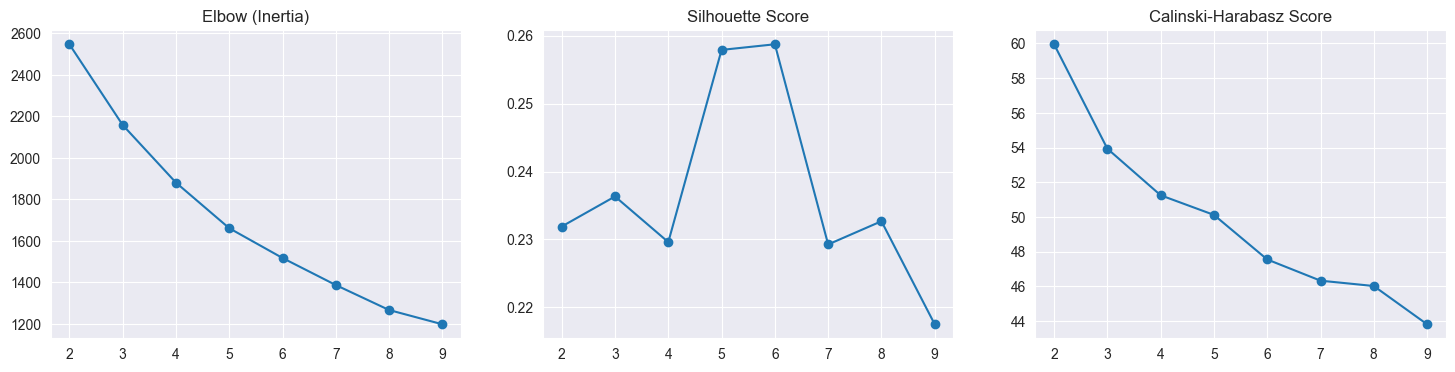

In [25]:
##%% ============================================
# 4. K-SELECTION: Elbow, Silhouette, CH-scores
# ===============================================
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

K_range = range(2, 10)
inertias = []
silhouettes = []
ch_scores = []

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X_pca)

    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_pca, labels))
    ch_scores.append(calinski_harabasz_score(X_pca, labels))

fig, ax = plt.subplots(1, 3, figsize=(18,4))

ax[0].plot(K_range, inertias, marker='o')
ax[0].set_title("Elbow (Inertia)")

ax[1].plot(K_range, silhouettes, marker='o')
ax[1].set_title("Silhouette Score")

ax[2].plot(K_range, ch_scores, marker='o')
ax[2].set_title("Calinski-Harabasz Score")

plt.show()



In [26]:
##%% ============================================
# 5. FIT FINAL K-MEANS MODEL
#    (Pick the K from elbow + silhouette)
# ===============================================
K_FINAL = 4  # <--- SET YOUR FINAL VALUE HERE

kmeans = KMeans(n_clusters=K_FINAL, random_state=42, n_init=50)
regimes = kmeans.fit_predict(X_pca)

df_regimes = pd.Series(regimes, index=df_X.index, name="Regime")
df_regimes.head()


2008-04    2
2008-05    1
2008-06    0
2008-07    0
2008-08    0
Freq: M, Name: Regime, dtype: int32

In [27]:
##%% ============================================
# 6. CLUSTER CENTROIDS (in original X-scale)
# ===============================================
centroids_scaled = kmeans.cluster_centers_
centroids_original = scaler.inverse_transform(
    pca.inverse_transform(centroids_scaled)
)

centroid_df = pd.DataFrame(
    centroids_original,
    columns=df_X.columns,
    index=[f"Regime {i}" for i in range(K_FINAL)]
)

centroid_df.style.background_gradient(cmap="coolwarm")


,CPI,WPI,REPO,REPO change,Ind_spread,Us_spread,Crude,Nifty Div Yield,Nifty PB,Nifty PE,Nifty CAPE,S&P CAPE,IND VIX,US VIX,IND VIX chg,US VIX chg,SP500
Regime 0,8.074197,4.902613,7.574327,0.002923,0.135556,1.734268,-0.013762,1.384129,3.190482,19.447524,20.157643,23.151918,19.724790,18.090730,0.028967,0.038437,0.001780
Regime 1,4.618234,2.371990,6.231508,-0.000724,0.370676,0.343342,-0.004460,1.272890,3.742085,24.038907,31.833249,31.408521,14.753392,16.407172,0.011763,0.030190,0.012108
Regime 2,8.189247,7.326114,4.640393,0.007837,1.502187,1.411778,0.048293,1.152381,3.826250,25.490731,30.180990,27.696688,23.403423,24.295532,-0.035256,-0.002613,0.017934
Regime 3,9.781138,3.385114,6.026758,-0.093160,1.026993,1.590535,-0.183798,1.899098,2.429160,14.008490,18.583490,16.806959,49.607925,47.249866,0.301915,0.073374,-0.048451


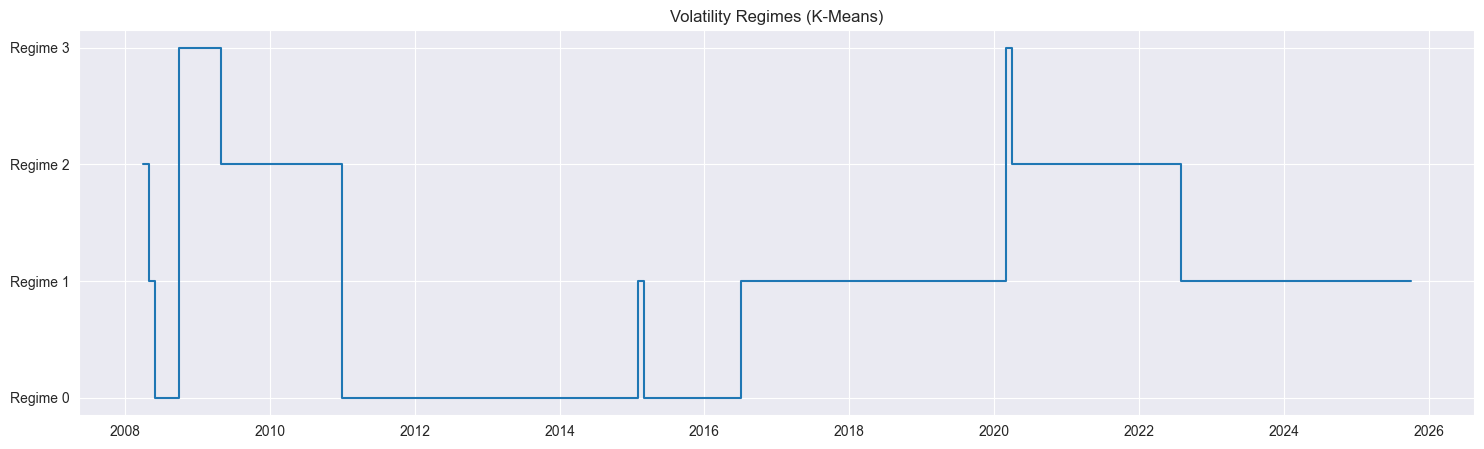

In [28]:
##%% ============================================
# 8. TIME-SERIES PLOT OF REGIMES
# ===============================================
plt.figure(figsize=(18,5))
plt.plot(df_regimes.index.to_timestamp(), df_regimes, drawstyle='steps-post')
plt.title("Volatility Regimes (K-Means)")
plt.yticks(range(K_FINAL), [f"Regime {i}" for i in range(K_FINAL)])
plt.grid(True)
plt.show()


In [29]:
##%% ============================================
# 9. REGIME-WISE Y METRICS (Returns, DD, Risk)
# ===============================================
combined = pd.concat([df_Y, df_regimes], axis=1)

regime_summary = combined.groupby("Regime").mean()
regime_summary.style.background_gradient(cmap="viridis")


,LogReturn_.NSEI,LogReturn_.NIFMDCP100,LogReturn_.NIFSMCP100,Return3m_.NSEI,Return3m_.NIFMDCP100,Return3m_.NIFSMCP100,Return6m_.NSEI,Return6m_.NIFMDCP100,Return6m_.NIFSMCP100,Return12m_.NSEI,Return12m_.NIFMDCP100,Return12m_.NIFSMCP100,Drawdown3m_.NSEI,Drawdown3m_.NIFMDCP100,Drawdown3m_.NIFSMCP100,Drawdown6m_.NSEI,Drawdown6m_.NIFMDCP100,Drawdown6m_.NIFSMCP100,Drawdown12m_.NSEI,Drawdown12m_.NIFMDCP100,Drawdown12m_.NIFSMCP100,SemiStd3m_.NSEI,SemiStd3m_.NIFMDCP100,SemiStd3m_.NIFSMCP100,SemiStd6m_.NSEI,SemiStd6m_.NIFMDCP100,SemiStd6m_.NIFSMCP100,SemiStd12m_.NSEI,SemiStd12m_.NIFMDCP100,SemiStd12m_.NIFSMCP100,FullStd3m_.NSEI,FullStd3m_.NIFMDCP100,FullStd3m_.NIFSMCP100,FullStd6m_.NSEI,FullStd6m_.NIFMDCP100,FullStd6m_.NIFSMCP100,FullStd12m_.NSEI,FullStd12m_.NIFMDCP100,FullStd12m_.NIFSMCP100,SemiStd3mAnnual_.NSEI,SemiStd3mAnnual_.NIFMDCP100,SemiStd3mAnnual_.NIFSMCP100,SemiStd6mAnnual_.NSEI,SemiStd6mAnnual_.NIFMDCP100,SemiStd6mAnnual_.NIFSMCP100,SemiStd12mAnnual_.NSEI,SemiStd12mAnnual_.NIFMDCP100,SemiStd12mAnnual_.NIFSMCP100,FullStd3mAnnual_.NSEI,FullStd3mAnnual_.NIFMDCP100,FullStd3mAnnual_.NIFSMCP100,FullStd6mAnnual_.NSEI,FullStd6mAnnual_.NIFMDCP100,FullStd6mAnnual_.NIFSMCP100,FullStd12mAnnual_.NSEI,FullStd12mAnnual_.NIFMDCP100,FullStd12mAnnual_.NIFSMCP100
Regime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.002240,0.003335,-0.001440,0.008793,0.014970,0.009965,0.017512,0.026734,0.015513,0.061419,0.085991,0.067103,-0.030844,-0.037529,-0.050543,-0.050554,-0.065191,-0.087580,-0.075761,-0.098498,-0.128305,0.029180,0.034157,0.044827,0.032363,0.039095,0.051470,0.032413,0.039204,0.051224,0.049480,0.059159,0.071900,0.051103,0.061049,0.073960,0.051399,0.061138,0.073961,0.101083,0.118322,0.155285,0.112109,0.135427,0.178297,0.112280,0.135808,0.177444,0.171405,0.204931,0.249070,0.177025,0.211480,0.256203,0.178052,0.211788,0.256208
1,0.001711,0.002240,-0.001034,0.023551,0.031631,0.026540,0.053352,0.069720,0.059915,0.113312,0.154250,0.132300,-0.022121,-0.031815,-0.039394,-0.031677,-0.046013,-0.064068,-0.036237,-0.060753,-0.096369,0.017574,0.026238,0.032419,0.020215,0.029690,0.037516,0.021911,0.031904,0.042322,0.036452,0.050776,0.059901,0.037872,0.052704,0.063362,0.038758,0.053533,0.066044,0.060878,0.090892,0.112302,0.070026,0.102849,0.129960,0.075902,0.110518,0.146607,0.126272,0.175893,0.207504,0.131193,0.182571,0.219491,0.134262,0.185444,0.228784
2,0.015156,0.023945,0.022149,0.067604,0.100415,0.099920,0.146483,0.220117,0.229742,0.274147,0.433269,0.433349,-0.015664,-0.014506,-0.022956,-0.027250,-0.031614,-0.052748,-0.033548,-0.038143,-0.069822,0.021149,0.019376,0.029516,0.027786,0.027879,0.039671,0.039686,0.043846,0.059429,0.056355,0.064987,0.077825,0.063645,0.074414,0.088567,0.072656,0.086503,0.103696,0.073262,0.067120,0.102246,0.096254,0.096574,0.137423,0.137475,0.151887,0.205870,0.195221,0.225120,0.269592,0.220471,0.257778,0.306804,0.251686,0.299654,0.359213
3,0.071239,0.070762,0.071309,0.006161,-0.030104,-0.055700,-0.123167,-0.175112,-0.261024,-0.360982,-0.450085,-0.572217,-0.063968,-0.096259,-0.125076,-0.189369,-0.232934,-0.317547,-0.348868,-0.431070,-0.554369,0.079552,0.107796,0.140223,0.105573,0.130645,0.176105,0.111420,0.134669,0.170626,0.122484,0.152722,0.190501,0.129873,0.155958,0.202692,0.122629,0.148499,0.182509,0.275578,0.373418,0.485746,0.365714,0.452568,0.610047,0.385972,0.466508,0.591065,0.424297,0.529044,0.659916,0.449894,0.540255,0.702147,0.424799,0.514416,0.632231


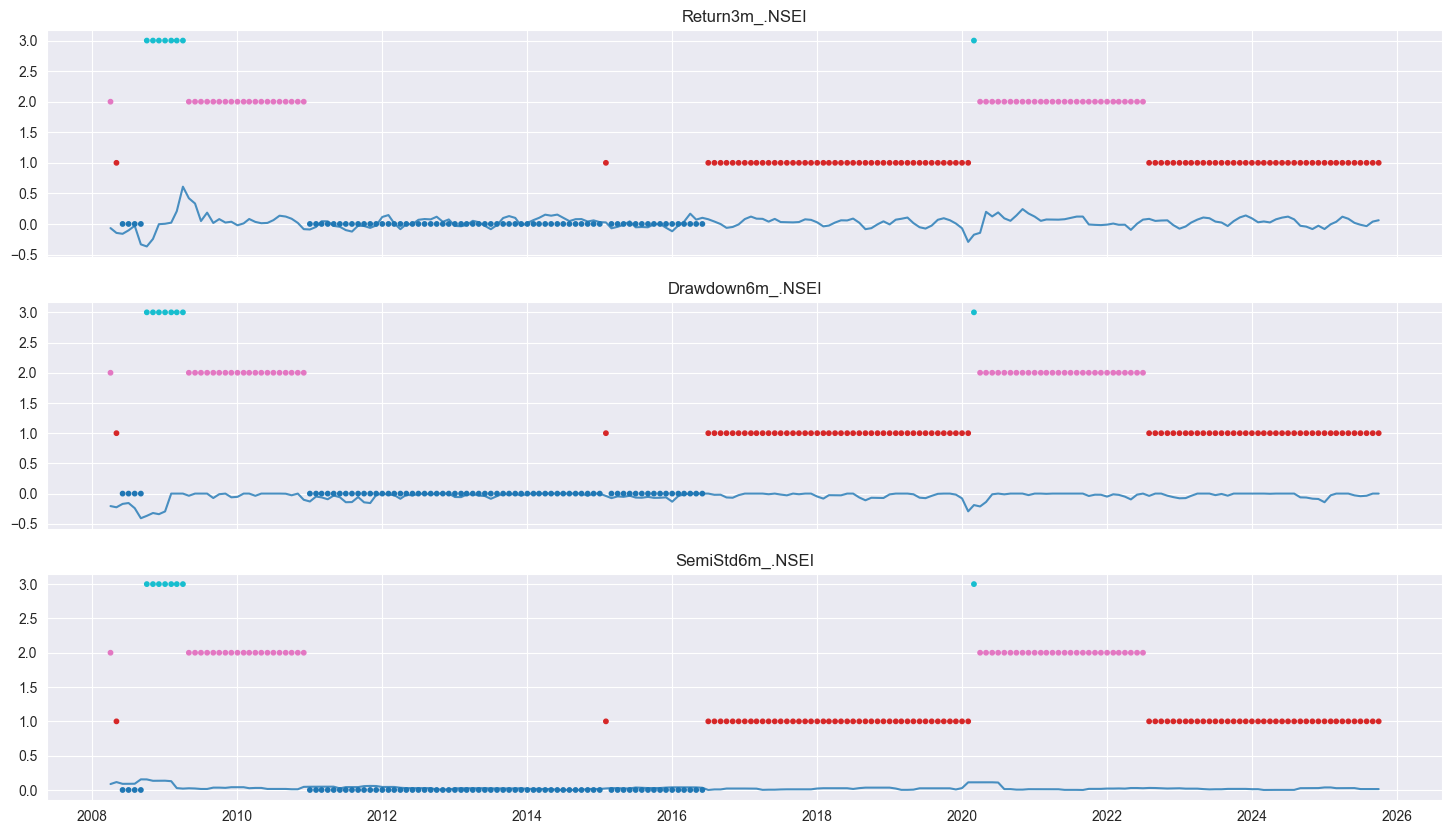

In [30]:
##%% ============================================
# 10. PLOT Y-METRICS VS REGIMES (Example)
# ===============================================
y_plot_cols = [
    "Return3m_.NSEI",
    "Drawdown6m_.NSEI",
    "SemiStd6m_.NSEI"
]

fig, ax = plt.subplots(len(y_plot_cols), 1, figsize=(18,10), sharex=True)
t = df_regimes.index.to_timestamp()

for i, col in enumerate(y_plot_cols):
    ax[i].plot(t, combined[col], label=col, alpha=0.8)
    ax[i].scatter(t, combined["Regime"], c=combined["Regime"], cmap='tab10', s=10)
    ax[i].set_title(col)
    ax[i].grid(True)

plt.show()


In [31]:
plot_df = pd.concat([monthly_index_prices.to_period('M'), df_regimes], axis=1)
plot_df = plot_df.dropna(subset=["Regime"])
plot_df

,.NSEI,.NIFMDCP100,.NIFSMCP100,Regime
2008-04,5165.90,7004.80,4203.00,2.0
2008-05,4870.10,6562.70,3968.77,1.0
2008-06,4040.55,5238.85,3289.44,0.0
2008-07,4332.95,5536.95,3366.68,0.0
2008-08,4360.00,5698.95,3430.39,0.0
...,...,...,...,...
2025-06,25517.05,59741.20,19075.10,1.0
2025-07,24768.35,57400.55,17966.85,1.0
2025-08,24426.85,55727.40,17227.00,1.0
2025-09,24611.10,56529.30,17562.75,1.0


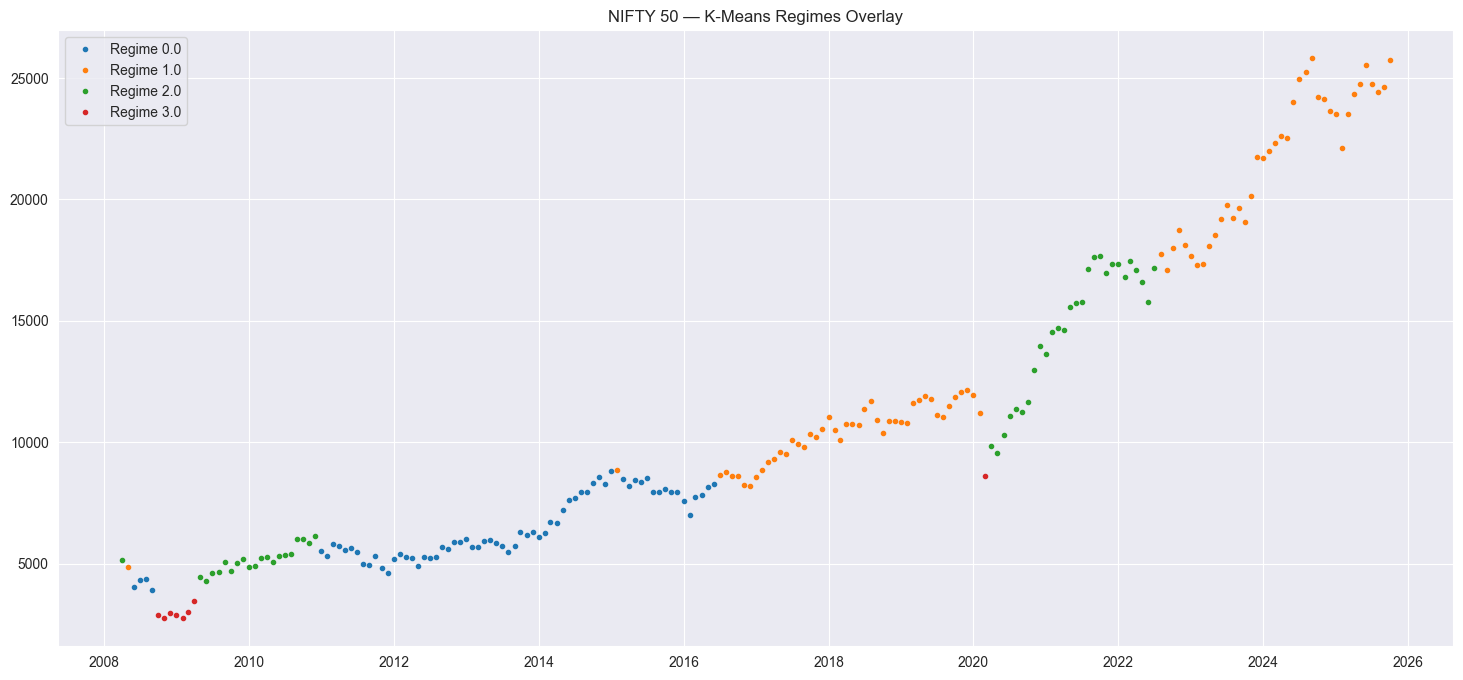

In [32]:
# ensure timestamp index
plot_df = plot_df.copy()
plot_df.index = plot_df.index.to_timestamp()

plt.figure(figsize=(18, 8))

for r in sorted(plot_df["Regime"].unique()):
    mask = plot_df["Regime"] == r
    plt.plot(
        plot_df.index[mask],
        plot_df[".NSEI"][mask],  # replace with correct column
        ".", 
        markersize=6,
        label=f"Regime {r}"
    )

plt.title("NIFTY 50 — K-Means Regimes Overlay")
plt.legend()
plt.grid(True)
plt.show()


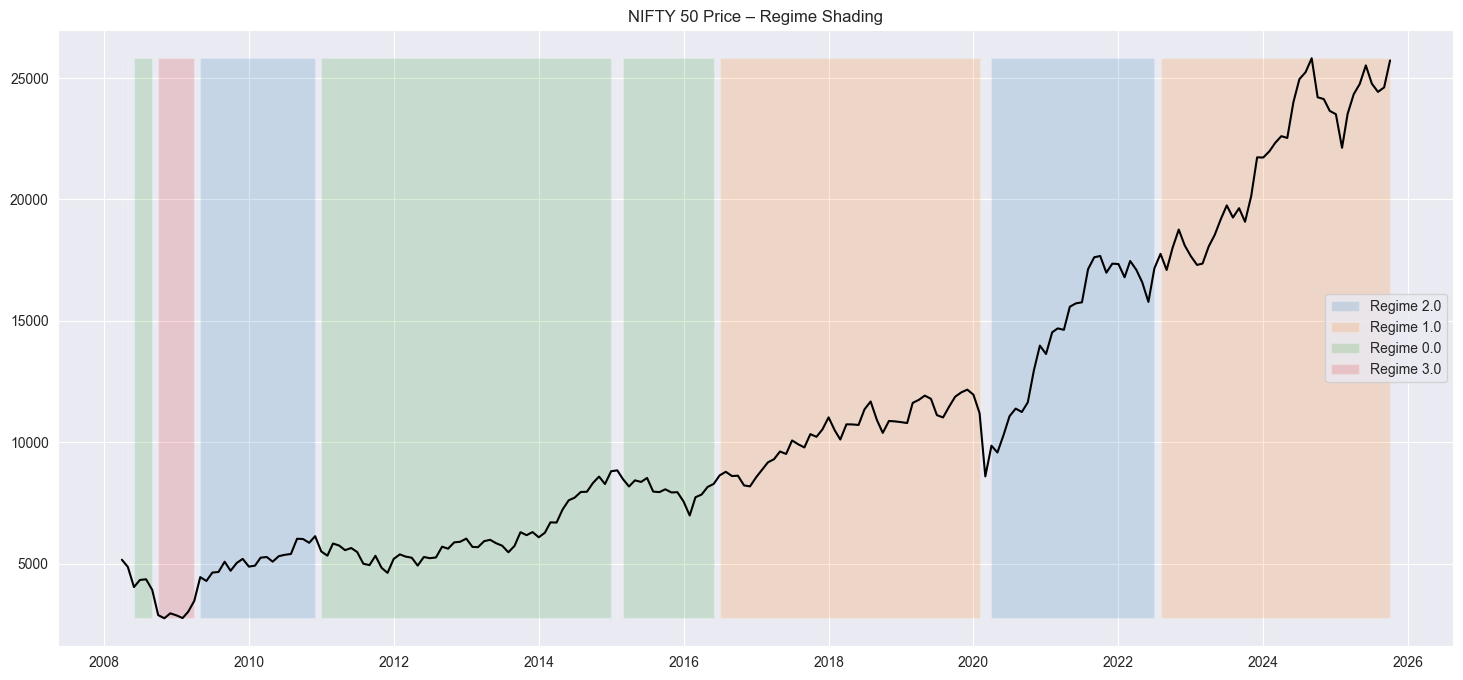

In [33]:
fig, ax = plt.subplots(figsize=(18, 8))

ax.plot(plot_df.index, plot_df[".NSEI"], color="black", linewidth=1.5)

for r in plot_df["Regime"].unique():
    mask = plot_df["Regime"] == r
    ax.fill_between(
        plot_df.index,
        plot_df[".NSEI"].min(),
        plot_df[".NSEI"].max(),
        where=mask,
        alpha=0.18,
        label=f"Regime {r}"
    )

ax.set_title("NIFTY 50 Price – Regime Shading")
ax.legend()
plt.show()


In [34]:
df_regimes = df_regimes.to_frame(name="Regime")
regime_y_df = df_regimes.join(lagged_y_metrics).dropna()
regime_y_df

,Regime,LogReturn_.NSEI,LogReturn_.NIFMDCP100,LogReturn_.NIFSMCP100,Return3m_.NSEI,Return3m_.NIFMDCP100,Return3m_.NIFSMCP100,Return6m_.NSEI,Return6m_.NIFMDCP100,Return6m_.NIFSMCP100,Return12m_.NSEI,Return12m_.NIFMDCP100,Return12m_.NIFSMCP100,Drawdown3m_.NSEI,Drawdown3m_.NIFMDCP100,Drawdown3m_.NIFSMCP100,Drawdown6m_.NSEI,Drawdown6m_.NIFMDCP100,Drawdown6m_.NIFSMCP100,Drawdown12m_.NSEI,Drawdown12m_.NIFMDCP100,Drawdown12m_.NIFSMCP100,SemiStd3m_.NSEI,SemiStd3m_.NIFMDCP100,SemiStd3m_.NIFSMCP100,SemiStd6m_.NSEI,SemiStd6m_.NIFMDCP100,SemiStd6m_.NIFSMCP100,SemiStd12m_.NSEI,SemiStd12m_.NIFMDCP100,SemiStd12m_.NIFSMCP100,FullStd3m_.NSEI,FullStd3m_.NIFMDCP100,FullStd3m_.NIFSMCP100,FullStd6m_.NSEI,FullStd6m_.NIFMDCP100,FullStd6m_.NIFSMCP100,FullStd12m_.NSEI,FullStd12m_.NIFMDCP100,FullStd12m_.NIFSMCP100,SemiStd3mAnnual_.NSEI,SemiStd3mAnnual_.NIFMDCP100,SemiStd3mAnnual_.NIFSMCP100,SemiStd6mAnnual_.NSEI,SemiStd6mAnnual_.NIFMDCP100,SemiStd6mAnnual_.NIFSMCP100,SemiStd12mAnnual_.NSEI,SemiStd12mAnnual_.NIFMDCP100,SemiStd12mAnnual_.NIFSMCP100,FullStd3mAnnual_.NSEI,FullStd3mAnnual_.NIFMDCP100,FullStd3mAnnual_.NIFSMCP100,FullStd6mAnnual_.NSEI,FullStd6mAnnual_.NIFMDCP100,FullStd6mAnnual_.NIFSMCP100,FullStd12mAnnual_.NSEI,FullStd12mAnnual_.NIFMDCP100,FullStd12mAnnual_.NIFSMCP100
2008-04,2,-0.058965,-0.065194,-0.057342,-0.067656,-0.094275,-0.125477,-0.154900,-0.179016,-0.195255,0.133689,0.162744,0.129384,-0.057260,-0.063114,-0.055729,-0.206643,-0.286651,-0.315817,-0.206643,-0.286651,-0.315817,0.066177,0.094078,0.112090,0.086445,0.115197,0.127405,0.061647,0.081702,0.090181,0.083151,0.115318,0.128477,0.097218,0.137061,0.150311,0.091127,0.110102,0.116674,0.229243,0.325895,0.388291,0.299454,0.399054,0.441345,0.213550,0.283023,0.312397,0.288045,0.399474,0.445058,0.336775,0.474794,0.520693,0.315674,0.381404,0.404169
2008-05,1,-0.186734,-0.225300,-0.187739,-0.146573,-0.160528,-0.127446,-0.341780,-0.430550,-0.432928,-0.064319,-0.123300,-0.118295,-0.217842,-0.252106,-0.217359,-0.226467,-0.283140,-0.275978,-0.341780,-0.430550,-0.432928,0.113058,0.135413,0.113334,0.115257,0.147412,0.148682,0.081891,0.104428,0.105213,0.123761,0.150945,0.129564,0.120821,0.154771,0.155169,0.105866,0.126811,0.127482,0.391644,0.469086,0.392602,0.399264,0.510651,0.515051,0.283678,0.361749,0.364469,0.428722,0.522889,0.448823,0.418536,0.536144,0.537523,0.366732,0.439286,0.441609
2008-06,0,0.069868,0.055342,0.023210,-0.161240,-0.209549,-0.198982,-0.156595,-0.242349,-0.258978,-0.043256,-0.103720,-0.129242,-0.110295,-0.156300,-0.151707,-0.170489,-0.235840,-0.258148,-0.294147,-0.398148,-0.419612,0.113058,0.135413,0.113334,0.089450,0.113567,0.110257,0.081891,0.104428,0.105213,0.120039,0.139132,0.114124,0.100639,0.125027,0.119237,0.106891,0.127452,0.127241,0.391644,0.469086,0.392602,0.309863,0.393409,0.381942,0.283678,0.361749,0.364469,0.415826,0.481967,0.395336,0.348624,0.433107,0.413049,0.370280,0.441508,0.440775
2008-07,0,0.006223,0.028838,0.018747,-0.104741,-0.131615,-0.135654,-0.165311,-0.213482,-0.244109,-0.023297,-0.057058,-0.100157,0.000000,0.000000,0.000000,-0.156004,-0.186422,-0.183823,-0.289740,-0.380539,-0.408629,0.107811,0.130077,0.108391,0.089450,0.113514,0.110256,0.081785,0.104236,0.105134,0.115166,0.134975,0.109751,0.100443,0.125532,0.119482,0.106825,0.127567,0.127291,0.373467,0.450600,0.375478,0.309863,0.393223,0.381938,0.283311,0.361085,0.364196,0.398947,0.467566,0.380190,0.347943,0.434855,0.413896,0.370051,0.441906,0.440948
2008-08,0,-0.106074,-0.152947,-0.210583,-0.029538,-0.066455,-0.155175,-0.171782,-0.216316,-0.262845,-0.219094,-0.287817,-0.331203,-0.100642,-0.141824,-0.189888,-0.240945,-0.301807,-0.338806,-0.361222,-0.468394,-0.520923,0.061242,0.088304,0.121580,0.090919,0.114312,0.117530,0.087329,0.113201,0.121444,0.073421,0.095371,0.122794,0.101754,0.126254,0.126225,0.105809,0.129859,0.138852,0.212149,0.305893,0.421166,0.314954,0.395987,0.407134,0.302517,0.392141,0.420695,0.254338,0.330375,0.425372,0.352485,0.437356,0.437255,0.366534,0.449844,0.480996
...,...,...,...,..

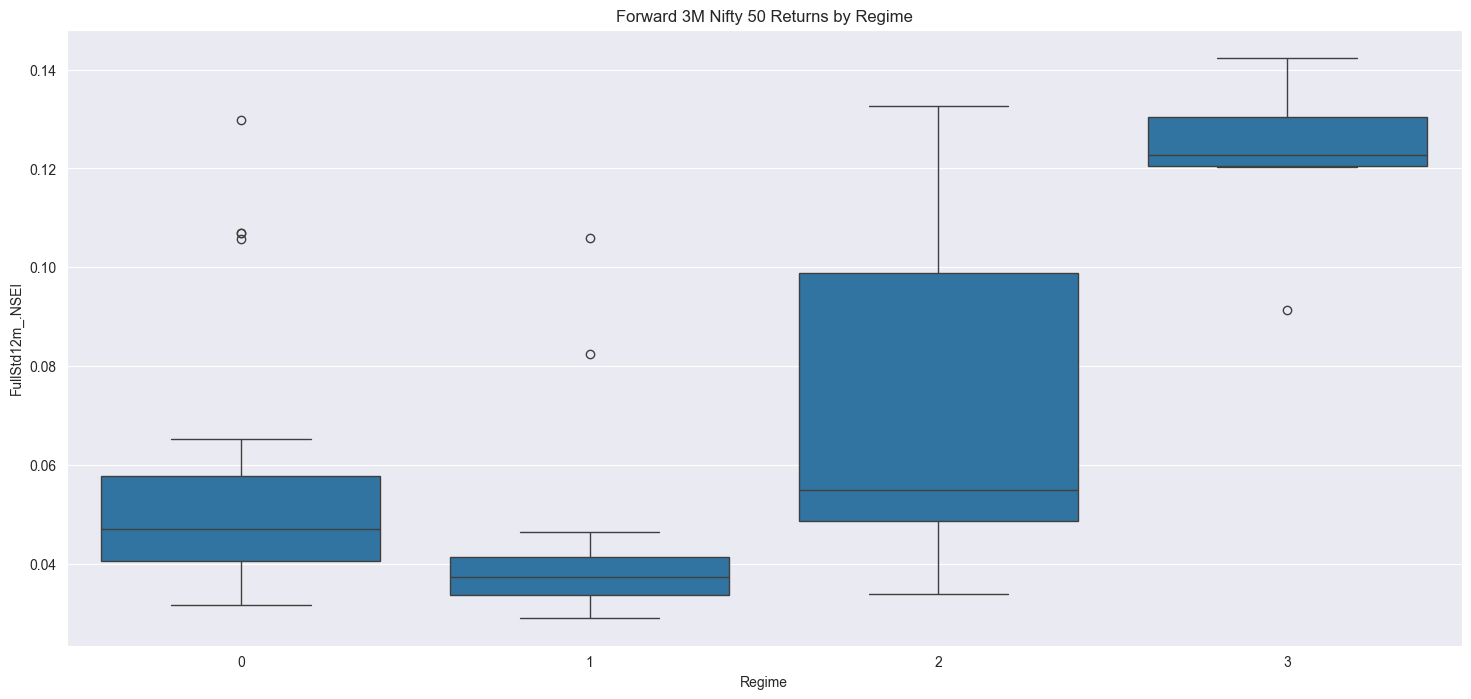

In [39]:
import seaborn as sns

plt.figure(figsize=(18, 8))
sns.boxplot(
    data=regime_y_df,
    x="Regime",
    y="FullStd12m_.NSEI"  # example
)
plt.title("Forward 3M Nifty 50 Returns by Regime")
plt.show()


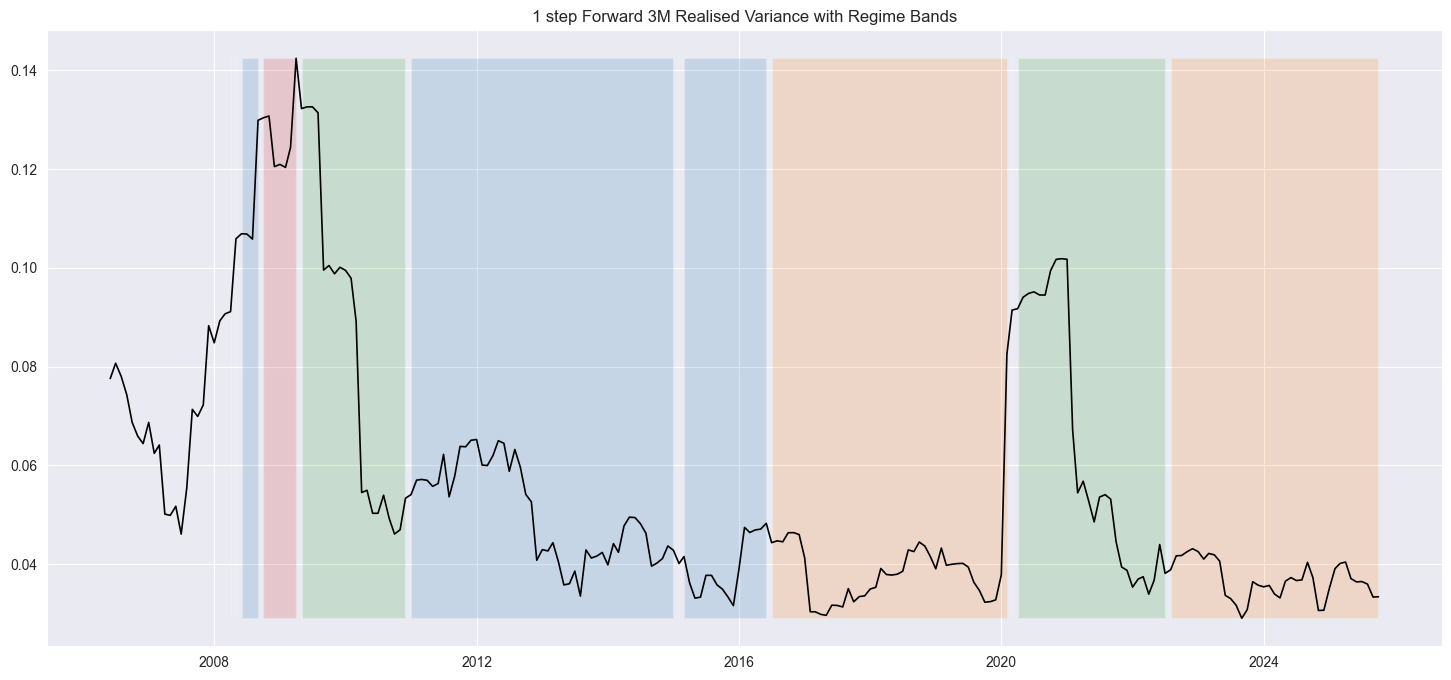

In [41]:
lagged_y_ts = lagged_y_metrics.copy()
lagged_y_ts.index = lagged_y_ts.index.to_timestamp()

df_regimes_ts = df_regimes.copy()
df_regimes_ts.index = df_regimes_ts.index.to_timestamp()

fig, ax = plt.subplots(figsize=(18, 8))

ax.plot(
    lagged_y_ts.index,
    lagged_y_ts["FullStd12m_.NSEI"],
    linewidth=1.2,
    color="black"
)

for r in sorted(df_regimes_ts.Regime.unique()):
    mask = df_regimes_ts["Regime"] == r
    ax.fill_between(
        lagged_y_ts.index,
        lagged_y_ts["FullStd12m_.NSEI"].min(),
        lagged_y_ts["FullStd12m_.NSEI"].max(),
        where=mask.reindex(lagged_y_ts.index, fill_value=False),
        alpha=0.18
    )

plt.title("1 step Forward 3M Realised Variance with Regime Bands")
plt.show()


